Accessing the dataset through web scraping

In [1]:
from bs4 import BeautifulSoup
import requests

In [2]:
url = 'https://www.kaggle.com/datasets/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')

In [3]:
print(soup)


<!DOCTYPE html>

<html lang="en">
<head>
<title>Twitter hate speech | Kaggle</title>
<meta charset="utf-8"/>
<meta content="index, follow" name="robots"/>
<meta content="Kaggle is the world’s largest data science community with powerful tools and resources to help you achieve your data science goals." name="description"/>
<meta content="email and messaging" name="keywords"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=5.0, minimum-scale=1.0" name="viewport"/>
<meta content="#008ABC" name="theme-color">
<script nonce="AEnU7kKuF6iYdqbHNk9CMg==" type="text/javascript">
    window["pageRequestStartTime"] = 1724528145445;
    window["pageRequestEndTime"] = 1724528145555;
    window["initialPageLoadStartTime"] = new Date().getTime();
  </script>
<script async="" defer="" id="gsi-client" nonce="AEnU7kKuF6iYdqbHNk9CMg==" src="https://accounts.google.com/gsi/client"></script>
<script nonce="AEnU7kKuF6iYdqbHNk9CMg==">window.KAGGLE_JUPYTERLAB_PATH = "/static/jl2-static/ju

In [4]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('train_E6oV3lV.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


Removing unnecesarry characters

In [7]:
import re

In [8]:
def remove_unnecessary_characters(tweet):
    return re.sub(r'\W+', ' ', tweet)

df['tweet'] = df['tweet'].apply(lambda x: remove_unnecessary_characters(x))


In [9]:
df.head()

,id,label,tweet
0,1,0,user when a father is dysfunctional and is so...
1,2,0,user user thanks for lyft credit i can t use ...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in ur...
4,5,0,factsguide society now motivation


Standardization

In [10]:
import nltk

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/awwabahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from nltk.corpus import wordnet     

In [13]:
def standardization(tweet):
    if tweet is None:
        return None
    
    tweet = tweet.lower().strip()
    corrected_words = []
    for word in tweet.split():
        corrected_word = wordnet.morphy(word) if wordnet.morphy(word) else word
        corrected_words.append(corrected_word)
    
    corrected_text = ' '.join(corrected_words)
    
    return corrected_text

df['tweet'] = df['tweet'].apply(standardization)  

In [14]:
df.head()

,id,label,tweet
0,1,0,user when a father be dysfunctional and be so ...
1,2,0,user user thanks for lyft credit i can t use c...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in urð...
4,5,0,factsguide society now motivation


Tokenization & Lemmitization

In [15]:
import spacy
nlp = spacy.load('en_core_web_sm')        

In [16]:
def tokenize_and_lemmatize(text):
    doc = nlp(text)  
    tokens = [token.text for token in doc]  
    lemmas = [token.lemma_ for token in doc]  
    return tokens, lemmas

In [17]:
df[['tokens', 'lemmas']] = df['tweet'].apply(lambda x: pd.Series(tokenize_and_lemmatize(x)))

In [18]:
df.iloc[31959]

id                                                    31960
label                                                     0
tweet     listening to sad song on a monday morning otw ...
tokens    [listening, to, sad, song, on, a, monday, morn...
lemmas    [listen, to, sad, song, on, a, monday, morning...
Name: 31959, dtype: object

Remove NA values

In [19]:
df.isnull().sum()

id        0
label     0
tweet     0
tokens    0
lemmas    0
dtype: int64

Featurization: TD-IDF & Word Embeddings

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['tweet'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [22]:
nlp = spacy.load("en_core_web_sm")

In [23]:
def word_embeddings(text):
    doc = nlp(text)  
    embeddings = [token.vector for token in doc]
    return embeddings

EDA

Average length of tweet (in characters)

In [26]:
df['tweet_length'] = df['tweet'].apply(len)

average_length = df['tweet_length'].mean()

print("Average length of tweet in characters:", average_length)

Average length of tweet in characters: 73.70874788811714


Average length of words (in characters)

In [27]:
def average_word_length(words):
    total_length = sum(len(word) for word in words)
    return total_length / len(words)

df['avg_word_length'] = df['tokens'].apply(average_word_length)

In [29]:
df.head()

,id,label,tweet,tokens,lemmas,tweet_length,avg_word_length
0,1,0,user when a father be dysfunctional and be so ...,"[user, when, a, father, be, dysfunctional, and...","[user, when, a, father, be, dysfunctional, and...",94,4.277778
1,2,0,user user thanks for lyft credit i can t use c...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thank, for, lyft, credit, I, can,...",112,4.380952
2,3,0,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesty]",19,5.666667
3,4,0,model i love u take with u all the time in urð...,"[model, i, love, u, take, with, u, all, the, t...","[model, I, love, u, take, with, u, all, the, t...",60,2.210526
4,5,0,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]",33,7.500000


The top most frequently occurring words

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/awwabahmed/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
from collections import Counter
from tqdm import trange
from nltk.corpus import stopwords

In [39]:
def clean(tweet):
    tweet = " ".join([word for word in tweet.split() if word not in stopwords.words('english')])
    return tweet

In [40]:
df['tweet'] = df['tweet'].apply(clean)
df.head(10)

,id,label,tweet,tokens,lemmas,tweet_length,avg_word_length
0,1,0,user father dysfunctional selfish drag kid dys...,"[user, when, a, father, be, dysfunctional, and...","[user, when, a, father, be, dysfunctional, and...",94,4.277778
1,2,0,user user thanks lyft credit use cause offer w...,"[user, user, thanks, for, lyft, credit, i, can...","[user, user, thank, for, lyft, credit, I, can,...",112,4.380952
2,3,0,bihday majesty,"[bihday, your, majesty]","[bihday, your, majesty]",19,5.666667
3,4,0,model love u take u time urð ð ð ð ð ð ð ð,"[model, i, love, u, take, with, u, all, the, t...","[model, I, love, u, take, with, u, all, the, t...",60,2.210526
4,5,0,factsguide society motivation,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]",33,7.500000
5,6,0,2 2 huge fan fare big talking leave chaos pay ...,"[2, 2, huge, fan, fare, and, big, talking, bef...","[2, 2, huge, fan, fare, and, big, talking, bef...",108,4.450000
6,7,0,user camping tomorrow user user user user user...,"[user, camping, tomorrow, user, user, user, us...","[user, camping, tomorrow, user, user, user, us...",63,4.818182
7,8,0,next school year year exam ð think ð school ex...,"[the, next, school, year, be, the, year, for, ...","[the, next, school, year, be, the, year, for, ...",126,4.521739
8,9,0,love land allin cavs champion cleveland clevel...,"[we, won, love, the, land, allin, cavs, champi...","[we, win, love, the, land, allin, cavs, champi...",71,5.545455
9,10,0,user user welcome gr8,"[user, user, welcome, here, i, m, it, s, so, gr8]","[user, user, welcome, here, I, m, it, s, so, gr8]",38,2.900000


In [42]:
def corpus(tweet):
    tokens = tweet.split()
    return tokens

In [43]:
df['tokens'] = df['tweet'].apply(corpus)
df.head()

,id,label,tweet,tokens,lemmas,tweet_length,avg_word_length
0,1,0,user father dysfunctional selfish drag kid dys...,"[user, father, dysfunctional, selfish, drag, k...","[user, when, a, father, be, dysfunctional, and...",94,4.277778
1,2,0,user user thanks lyft credit use cause offer w...,"[user, user, thanks, lyft, credit, use, cause,...","[user, user, thank, for, lyft, credit, I, can,...",112,4.380952
2,3,0,bihday majesty,"[bihday, majesty]","[bihday, your, majesty]",19,5.666667
3,4,0,model love u take u time urð ð ð ð ð ð ð ð,"[model, love, u, take, u, time, urð, ð, ð, ð, ...","[model, I, love, u, take, with, u, all, the, t...",60,2.210526
4,5,0,factsguide society motivation,"[factsguide, society, motivation]","[factsguide, society, now, motivation]",33,7.500000


In [44]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['tokens'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 31962/31962 [00:00<00:00, 148448.50it/s]


297141

In [45]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('user', 17582),
 ('ð', 15238),
 ('â', 4611),
 ('love', 3006),
 ('day', 2311),
 ('amp', 1776),
 ('happy', 1762),
 ('get', 1543),
 ('life', 1221),
 ('u', 1172)]

In [46]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

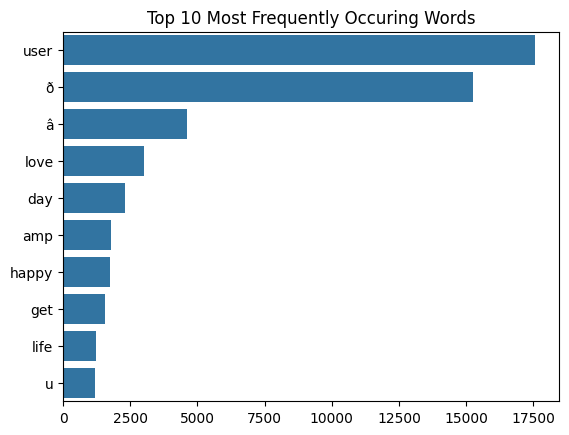

In [48]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()